# Introducción a tecnicas de análisis de datos para la radiación de fondo de microondas


### Jeff McMahon y Renée Hložek. Traducción por Cristian Vargas

La radiación de fondo de microondas (en inglés cosmic microwave background o CMB) es la luz observable más antigua del universo. Como tal, posee una gran cantidad de información cosmológica que incluye: (1) Señales provenientes del universo temprano (anisotropías primarias), y (2) distorciones marcadas a medida que esta luz se propaga a través del universo y se encuentra con estructuras ya colapsadas (anisotropías secundarias). Las mediciones de estas señales nos proporcionan medidas importantes y restricciones sobre parámetros inflacionarios, energía oscura, materia oscura, la suma de las masas de los neutrinos y muchos otros procesos astrofísicos. El desarrollo de instrumentos y técnicas de análisis del CMB está evolucionando rápidamente.

Este cuadernillo proporciona una introducción a las técnicas de ánalisis para mapas de CMB en lo que respecta a instrumentos de CMB de alta resolución como el Telescopio Cosmológico de Atacama (en inglés Atacama Cosmology Telescope o ACT) y el Telescopio del Polo Sur (en inglés South Pole Telescope o SPT). Estos instrumentos de última generación tienen miles de detectores (píxeles) desplegados en telescopios de 6 y 10 metros respectivamente que producen haces de 1 minuto de arco a una frecuencia de 150 GHz. Estos telescopios observan escaneando el cielo. Los datos de cada detector se leen a alta velocidad (normalmente > 50 Hz) para producir "flujos de tiempo del detector" que se graban junto con la información de donde apunta el telescopio y otros datos complementarios. Se utilizan códigos sofisticados para convertir estos flujos de tiempo en mapas del cielo CMB. Estos mapas pueden tener ruido correlacionado que debe tenerse en cuenta en el análisis de datos. Los algoritmos de creación de mapas no se describen en detalle aquí, pero representan un desafío de big data muy interesante, ya que requieren limpiar los flujos de tiempo mediante filtrado, la identificación de eventos transitorios y, en última instancia, la compresión de Terabytes de datos en mapas que normalmente tienen 100 Megabytes o menos.

Mostramos como ejemplo mapas de SPT (arriba, tomado del articulo de phys.org del 2 de abril de 2012 titulado "South Pole Telescope afina medidas de la energía oscura y neutrinos) y ACTPol (abajo, tomado del artículo cientifico sobre la polarización del CMB, Naess et al. 2014). Muchas características son visibles en estos mapas, incluyendo: (1) el CMB primario visible como ondas (nubes) en los mapas de intensidad (2) galaxias de nucleo activo y otras fuentes puntuales astrofísicas que se manifiestan como puntos brillantes (3) cúmulos de galaxias que aparecen como fuentes puntuales oscurecidas y (4) franjas horizontales (en el mapa de SPT) que son el resultado del ruido y filtrado del mapa. La figura de ACTPol muestra varios mapas, T es temperatura, Q y U son parámetros de Stokes de polarización, E y B también son polarización pero se descomponen en una base tal que E es la amplitud del componente irrotacional (sin rotor) y B es la amplitud del componente solenoidal (sin divergencia) del campo vectorial de polarización. 

![](http://cdn.phys.org/newman/gfx/news/hires/2012/newcosmologi.jpg)

![](http://www.classe.cornell.edu/rsrc/Home/NewsAndEvents/CornellExperimentalCosmologyNews20140528/maps_b.png)

Si bien los instrumentos actuales (ACTPol y SPTPol) tienen múltiples frecuencias y son sensibles a la polarización, por simplicidad consideraremos solo la frecuencia de 150 GHz y solo temperatura. Agregar canales de frecuencia adicionales o polarización cuesta más trabajo y haría que esta presentación fuera más confusa. Por lo tanto, dejamos estas complicaciones para un tratamiento futuro y nos enfocamos solo en la temperatura. Esto nos permite mostrar conceptos básicos de análisis de Monte Carlo tanto del espectro de potencia angular como de las técnicas de filtro adaptado para estudiar el efécto Sunyaev-Zel'dovich (SZ). 

Este curso está organizado de la siguiente manera. Comenzamos construyendo una simulación del cielo CMB incluyendo el CMB primario, fuentes puntuales (galaxias de nucleo activo y galaxias de polvo), el efecto SZ, y (si hay tiempo) la lente del CMB. A estos mapas, incorporamos efectos que incluyen el haz del telescopio, y el ruido instrumental y atmosférico.  A continuación, presentamos varias técnicas de análisis, incluida la estimación de Monte Carlo de los espectros de potencia y las técnicas de filtros adaptados para la extración de fuentes. Se presenta un ejemplo de apilamiento como ejemplo de una correlación cruzada con conjuntos de datos externos. La correlación cruzada es un campo de investigación muy activo.

En aras de la simplicidad, utilizamos distribuciones aproximadas para recuentos de fuentes y SZ con combinaciones de distribuciones exponenciales y de Poisson. Explicamos explícitamente dónde hacemos estas aproximaciones.

## Códigos preliminares

Usamos las siguientes librarias en este código. Todas están disponibles a través de Anaconda

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits


## linea de código para graficar dentro del cuadernillo
%matplotlib inline


## linea de código para cambiar el directorio base
#%cd /Directorio/donde/estan/los/datos/


## Sección 1.1: Espectro de Potencia Angular
La mayoría de la información del CMB está contenida en su espectro de potencia angular. Este espectro es la amplitud al cuadrado de la magnitud de las fluctuaciones de temperatura en función de $\ell$. Aquí $\ell$ es la variable que has visto antes en los armónicos esféricos (por ejemplo, $Y_{\ell m}$). $\ell = 0$ corresponde a una temperatura constante en el cielo, $\ell = 200$ corresponde aproximadamente a escalas de $1^\circ$. Para un conjunto de parámetros cosmológicos de entrada, estos espectros se pueden calcular con códigos que incluyen CMBFAST o CAMB el equivalente moderno. El especto que vamos a utilizar a continuación se calculó con la interfaz web de CAMB dentro de LAMBDA (el repositorio de CMB de la NASA)

https://lambda.gsfc.nasa.gov/toolbox/camb_online.html

Es divertido jugar con los parámetros y ver cómo va cambiando el espectro.

Las ubicaciones relativas y las amplitudes de los peaks contienen una gran cantidad de información. El descubrimiento del primer peak en $\ell \sim 200$ proporcionó la primera medida definitiva de que nuestro universo es plano. La forma del espectro delimita una amplia variedad de parámetros cosmológicos, incluida la energía oscura y la materia oscura. La caída a $\ell$ alto (por ejemplo $\ell \gtrsim 1000$) se denomina cola de amortiguamiento (damping tail) y proporciona restricciones en el indice espectral de la inflación. Una gran cantidad de parámetros cosmológicos están restringidos por las mediciones de este espectro.

Actualmente el espectro de temperatura está bien medido y las fronteras abiertas son la polarización y las anisotropías secundarias que no están incluidas en este espectro. Ahora construiremos cielos simulados que incluyen la anisotropía CMB y las anisotropías secundarias. Despues de eso, mostraremos cómo estimar el espectro de potencia a partir de datos de mapas utilizando técnicas de Monte Carlo. Estas técnicas de Monte Carlo se pueden utilizar para la interpretación de datos de polarización y para la interpretación de correlaciones cruzadas entre CMB y otros datos de sondeos astronómicos. 

En la siguiente linea se explica cómo leer y graficar el espectro de temperatura CMB de una simulación de CAMB.

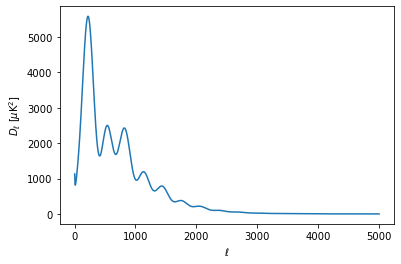

In [2]:
# leer un archivo que contiene un espectro CMB

ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True)
plt.plot(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

Este gráfico es el espectro de potencia angular de las anisotropías de temperatura del CMB. Es tradicional graficar $D_\ell$ que deja ver la variación en distintas de escalas angulares. Este termino está relacionado con el espectro de potencia angular $C_\ell$ por la relación $D_\ell = \frac {\ell (\ell+1)} {2 \pi} C_\ell$. El termino correcto a usar para crear mapas de CMB es $C_\ell$, pero $D_\ell$ es lo que típicamente se grafica.

<font color='red'> EJERCICIO: </font> Ir a NASA LAMBDA CAMB y generar un espectro de potencia para un modelo de universo con un componente extraño a tu elección (por ejemplo, con curvatura espacial, sin energía oscura, o algún otro componente extraño). Hacer un diagrama comparando este espectro de potencia con el espectro estándar de arriba. Compararemos resultados.

In [3]:
# Tu codigo y graficos van aquí

Comenta aquí cómo se compara el espectro de este modelo extraño de universo con el espectro de la cosmología estandar.

## Sección 1.2: Mapa de Anisotropías en Temperatura

En este paso generaremos un mapa simulado del cielo CMB con el espectro que leímos y graficamos arriba. Dado que el espectro de potencia es una función en $\ell$, necesitamos hacer gran parte del trabajo en el espacio armónico. Si estuviéramos generando un mapa del cielo completo, necesitaríamos trabajar con armónicos esféricos. Aquí consideraremos una pequeña porción del cielo (${\sim}10^\circ \times 10^\circ$) donde se puede hacer la aproximación de "cielo plano" y reemplazamos $\ell$ por $k = (k_x^2 + k_y^2)^{1/2}$. Hay una dependencia lineal entre estas variables definidas por $\ell = 2 \pi k$.

En la aproximación de cielo plano, generamos un mapa CMB de la siguiente forma: (1) Generamos un espectro de potencia 2D girando el espectro anterior (correctamente normalizado) alrededor del eje en coordenadas polares, (2) generamos un mapa aleatorio gaussiano con varianza unitaria como nuestra "realización aleatoria", (3) multiplicamos los mapas generados en (1) y (2), y (4) calculamos la transformada de Fourier de esto para obtener el mapa en espacio real. Proporcionamos una función para hacer esto y una función para graficar este (y otros mapas) con una escala de color uniforme.

promedio del mapa: -0.10567698923235055 , media cuadrática (rms) del mapa: 101.91648830732413


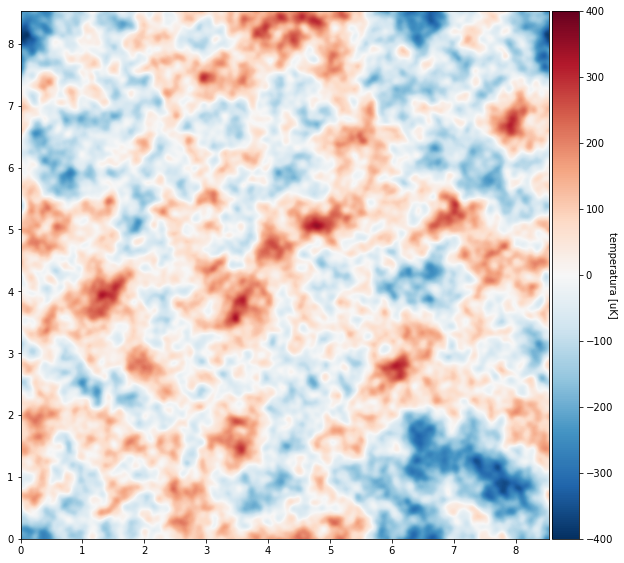

<Figure size 432x288 with 0 Axes>

In [7]:
## variables para ajustar el tamaño del mapa

N = 2**10   #este es el numero de píxeles en una dimensión lineal
            #dado que usaremos muchas transformadas de Fourier
            #usaremos un factor de 2^N
tamaño_pix = 0.5 # tamaño de un pixel en arcominutos


##variables para configurar el gráfico del mapa
c_min = -400  # mínimo para la barra de color
c_max = 400   # máximo para la barra de color
X_ancho = N*tamaño_pix/60.  # ancho horizontal del mapa en grados
Y_ancho = N*tamaño_pix/60.  # ancho vertical del mapa en grados

def crear_mapa_CMB_T(N,tamaño_pix,ell,DlTT):
    """crea una realización de un mapa del cielo CMB simulado dado un DlTT de entrada en función 
    del tamaño de píxel (tamaño_pix) requerido y el número N de píxeles en la dimensión lineal."""
    #np.random.seed(100)
    # convertir Dl a Cl
    ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
    ClTT[0] = 0. #establece el monopolo y el dipolo del espectro Cl a cero
    ClTT[1] = 0.
    
    # crea un sistema de coordenadas de espacio real en dos dimensiones (2D)
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) #crear un arreglo de tamaño N entre -0.5 y +0.5
    
    #calcula la matriz del producto exterior: X[i, j] = onesvec[i] * inds[j] para i,j
    #en range(N), que es solo N filas copias de inds - para la dimensión x
    X = np.outer(onesvec,inds) 
    # calcula la transpuesta para la dimensión y
    Y = np.transpose(X)
    # calcula la componente radial R
    R = np.sqrt(X**2. + Y**2.)
    
    # crea un espectro de potencia CMB 2D
    pix_to_rad = (tamaño_pix/60. * np.pi/180.) # tamaño_pix en arcominutos a grados y luego de grados a radianes
    ell_factor_escala = 2. * np.pi /pix_to_rad # ahora relacionando el tamaño angular en radianes con multipolos
    ell2d = R * ell_factor_escala # crea un espacio de Fourier análogo al vector R del espacio real
    ClTT_expandido = np.zeros(int(ell2d.max())+1) 
    # hace un espectro de Cl expandido (de ceros) que llega hasta el tamaño del vector ell 2D
    ClTT_expandido[0:(ClTT.size)] = ClTT # rellena los Cls hasta el máximo del vector ClTT

    # el espectro de Cl 2D se define en el vector múltiple establecido por la escala de píxeles
    CLTT2d = ClTT_expandido[ell2d.astype(int)] 
    #plt.imshow(np.log(CLTT2d)) #función para visualizar el logaritmo del espectro 2D
    
    # ahora creamos una realización del CMB con el espectro de potencia dado en el espacio real
    arreglo_aleatoreo_para_T = np.random.normal(0,1,(N,N))
    # tomamos la FFT ya que estamos en espacio de Fourier
    FT_arreglo_aleatoreo_para_T = np.fft.fft2(arreglo_aleatoreo_para_T) 
    
    FT_2d = np.sqrt(CLTT2d) * FT_arreglo_aleatoreo_para_T  
    # hemos usado la raiz cuadrada ya que el espectro de potencia es T^2
    plt.imshow(np.real(FT_2d))

    #hacemos un gráfico del mapa simulado en espacio de Fourier, tenga en cuenta que las etiquetas de los ejes x e y
    #deben corregirse
    #Plot_CMB_Map(np.real(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),0,np.max(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),ell2d.max(),ell2d.max())  ###
    
    # nos movemos de vuelta desde el espacio ell al espacio real
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # nos movemos de vuelta desde espacio pixel al espacio mapa
    CMB_T = CMB_T/(tamaño_pix /60.* np.pi/180.)
    # solo queremos graficar la componente real
    CMB_T = np.real(CMB_T)

    ## devuelve el mapa
    return(CMB_T)
  ###############################

def Graficar_Mapa_CMB(Mapa_a_Graficar,c_min,c_max,X_ancho,Y_ancho):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("promedio del mapa:",np.mean(Mapa_a_Graficar),", media cuadrática (rms) del mapa:",np.std(Mapa_a_Graficar))
    plt.gcf().set_size_inches(10, 10)
    im = plt.imshow(Mapa_a_Graficar, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_ancho,0,Y_ancho])
    plt.ylabel('ángulo $[^\circ]$')
    plt.xlabel('ángulo $[^\circ]$')
    cbar.set_label('temperatura [uK]', rotation=270)
    
    plt.show()
    return(0)
  ###############################

## crea un mapa CMB T
CMB_T = crear_mapa_CMB_T(N,tamaño_pix,ell,DlTT)
Graficar_Mapa_CMB(CMB_T,c_min,c_max,X_ancho,Y_ancho)
plt.savefig('cmb1.png')
plt.clf()


Este gráfico de contorno muestra el mapa CMB simulado que acabamos de generar. Si lo generas varias veces, verás que se obtienen diferentes patrones; sin embargo, verás que el tamaño típico de las nubes más brillantes y más oscuras permanecerá alrededor de $1^\circ$, correspondiente al pico del espectro de potencia angular. Todos los mapas del cielo simulados se muestran con la misma escala de colores para permitir la comparación visual.

<font color='red'>EJERCICIO: </font> Hacer una función llamada "crear_mapa_CMB_visualizando_pasos" copiando el codigo de "crear_mapa_CMB_T" cambiando el nombre de la función. En esta versión, haga un gráfico de (1) el espectro de potencia CMB 2D y (2) la realización del espectro en espacio armónico. Ejecute esto varias veces para que cómo cambia la realización en cada iteración.

In [5]:
# Tu código y gráficos van aquí

Discutir: (1) cómo se relaciona el espectro de potencia CMB con la realización, y (2) cómo se relaciona la realización en el espacio armónico con el mapa CMB.

<font color='red'>EJERCICIO: </font>  Vuelve a ejecutar tu código con el espectro de potencia de un universo con un modelo extraño. Compara cómo se ven los mapas. ¿Cómo cambia el mapa producido si estableces el espectro de potencia original a cero en escalas pequeñas (por ejemplo, $\ell > 1000$)? ¿Qué pasa si pones todas las escalas grandes en cero?

In [6]:
## Tu código va aquí

Tus comentarios van aquí